In [4]:
import csv 
import numpy as np 
import pandas as pd
import sys

sys.path.append('../modules/')

import matplotlib.pyplot as plt
from importlib import reload
import subprocess as sp
from subprocess import Popen
import os

import notepicker
import writeCmixSco_GRAN_v2 as wRT_gran
import writeCmixSco_WT_ac as wRT_wt
# _ac stands for autocheck

%matplotlib inline

# ======================================================
# autocheck for your RTcmix installation type: 
cmixStatus, cmixResult = sp.getstatusoutput("CMIX")
if cmixStatus == 0:
    cmixInstalled = True
    print("CMIX found.")
else:
    cmixInstalled = False
    print("CMIX not found, using pyGoRTcmix instead.")
# ======================================================

plt.rcParams['figure.figsize'] = [12, 10]

CMIX not found, using pyGoRTcmix instead.


In [33]:
target_file = '../data/cluster_outputs/riot_games_LOL/v2/756260657.csv'

dat = []

with open(target_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            dat.append(row)
            line_count += 1
    print(f'Processed {line_count} lines.')

Column names are sent_time, raw_chat_message, processed_chat_message, cluster_num, x, y
Processed 83398 lines.


In [34]:
dat = pd.DataFrame(dat, columns = ['time', 'msg', 'msg_clean', 'cluster', 'x', 'y'])

In [35]:
n_octaves_total = 4
root_note  = 110.0
ints_per_oct = 12

# chromatic scale of n octaves: 
intervals = np.linspace(0,n_octaves_total,int(n_octaves_total*ints_per_oct))
pitches = root_note*(2**intervals)
print(pitches)

[ 110.          116.68425542  123.77468603  131.29597345  139.2742991
  147.73743536  156.71484221  166.23776979  176.33936719  187.05479783
  198.42136189  210.47862611  223.26856154  236.83568966  251.22723732
  266.49330116  282.68702201  299.86476982  318.08633994  337.41516123
  357.91851687  379.66777856  402.73865499  427.21145533  453.17136884
  480.70876138  509.91948996  540.90523646  573.77386154  608.63978013
  645.62435967  684.85634263  726.47229464  770.61707985  817.44436525
  867.11715551  919.80836049  975.70139703 1034.99082751 1097.88303705
 1164.59695197 1235.36480187 1310.432928   1390.06264075 1474.53112931
 1564.13242653 1659.17843244 1760.        ]


In [36]:
print(dat)

                  time                                                msg  \
0      00:00:09.845000  catJAM catJAM catJAM catJAM catJAM catJAM catJ...   
1      00:00:18.481000                                      STARTFARM BBY   
2      00:00:41.381000  EU CANT WIN WITH 28 COUNTRIES KEKW EU CANT WIN...   
3      00:00:41.469000                                                  F   
4      00:00:45.615000                                                : D   
...                ...                                                ...   
83392  07:38:42.115000        @Azufre23 Well TSM and TL might make it out   
83393  07:38:46.566000  even when lck doesn't win worlds they still us...   
83394  07:38:47.159000  IF YOU WOULD BE SO ENTUSIASM FOR WORLD HUNGER ...   
83395  07:38:48.241000  ♿ MAKE WAY NA PASSING BY ♿ DIDN'T GET OUT OF G...   
83396  07:38:49.632000                                   NA: not american   

                                            msg_clean cluster           x  

In [37]:
times = []
clusters = []


for index, row in dat.iterrows():
    if index > 0: 
        time_split = [float(x) for x in row['time'].split(':')]
        times.append(time_split[0]*3600+time_split[1]*60+time_split[2]-18)
        clusters.append(row['cluster'])

In [38]:
print(dat['time'])
print(len(times))
print(set(clusters))

0        00:00:09.845000
1        00:00:18.481000
2        00:00:41.381000
3        00:00:41.469000
4        00:00:45.615000
              ...       
83392    07:38:42.115000
83393    07:38:46.566000
83394    07:38:47.159000
83395    07:38:48.241000
83396    07:38:49.632000
Name: time, Length: 83397, dtype: object
83396
{'2', '1', '0', '4', '9', '7', '8', '5', '3', '6'}


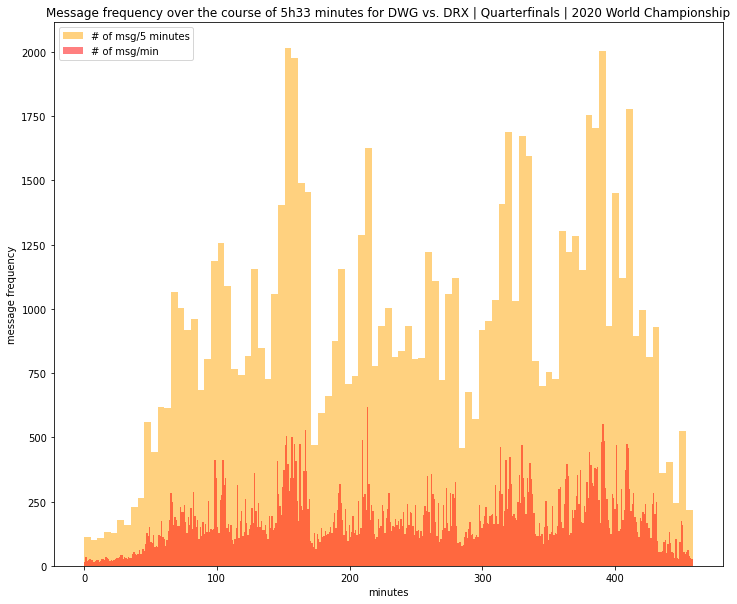

In [39]:
times_plot = [x/60 for x in times]

dat_5min = plt.hist(times_plot, bins = int(times[-1]/300), alpha=0.5, label='# of msg/5 minutes', color = 'orange')
dat_1min = plt.hist(times_plot, bins = int(times[-1]/60), alpha=0.5, label='# of msg/min', color = 'red')

plt.title('Message frequency over the course of 5h33 minutes for DWG vs. DRX | Quarterfinals | 2020 World Championship')
plt.xlabel("minutes")
plt.ylabel("message frequency")
plt.legend()
plt.show()

In [41]:
busiest_minute = list(dat_1min[0]).index(max(dat_1min[0]))
print(max(dat_1min[0]))
print(busiest_minute)

618.0
213


In [42]:
window=5
# start_time = (busiest_minute*60)-((window-1)*60*0.5)
# end_time = start_time+(window*60)
start_time = busiest_minute*60
end_time = start_time + 60

indexes = [idx for idx, x in enumerate(times) if x > start_time and x < end_time]
start_ind = indexes[0]
end_ind = indexes[-1]

times_window, clusters_window = times[start_ind:end_ind], clusters[start_ind:end_ind]
first_time = times_window[0]
times_window = [x-first_time for x in times_window]

clusters_window = [pitches[int(int(x)*len(pitches)/len(set(clusters)))] for x in clusters_window]

In [46]:
print(len(indexes))
print(start_time, end_time)
print(start_ind, end_ind)

536
12780 12840
33936 34471


In [22]:
# (4) write RTcmix Wavetable score
reload(wRT_wt)
base_name = 'test_gotRhythm2'
trim = -1
tones_dict = {}
# tones_dict['times'] = np.asarray(times[:trim])
tones_dict['times'] = times_window
# tones_dict['notes'] = np.asarray(notes[:trim])
# tones_dict['durs'] = np.asarray(durs[:trim]) 

# tones_dict['times'] = np.ones(len(notes[:trim]))
tones_dict['notes'] = clusters_window
tones_dict['durs'] = np.ones(len(times_window))*0.5
tones_dict['amps'] = np.ones(len(times_window))*2000
tones_dict['pans'] = np.ones(len(times_window))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

test_gotRhythm2.sco
CMIX not found; rtoutput() will not be used in score.


In [24]:
dur_sound = window*60

if cmixInstalled:
    cmix_cmd = 'CMIX < ' + base_name + '.sco'
    print(cmix_cmd)
else:
    dur = str(dur_sound)
    cmix_cmd = os.path.abspath('/Users/calvinlu/Documents/sonification/pyGoRTcmix/Contents/MacOS/pyGoRTcmix') + ' -inputscore ' + os.path.abspath(base_name + '.sco') + ' -output ' + os.path.abspath(base_name + '.wav') + ' -dur ' + dur
    print(cmix_cmd)

# the ! tells the notebook to run a command in the terminal
if sys.platform == 'win32':
    ! dir *.sco
else:
    ! ls *.sco

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print("\n" + "hopefully i just wrote your sound file; is it here?" + "\n")
if sys.platform == 'win32':
    ! dir *.wav
else:
    ! ls *.wav

#sp.run(['mv', score_name, '../3_output_nogit'])
#sp.run('mv *.wav ../3_output_nogit/', shell=True)

/Users/calvinlu/Documents/sonification/pyGoRTcmix/Contents/MacOS/pyGoRTcmix -inputscore /Users/calvinlu/Documents/bot/TwitchSonification/clustering/test_gotRhythm2.sco -output /Users/calvinlu/Documents/bot/TwitchSonification/clustering/test_gotRhythm2.wav -dur 300
test_gotRhythm2.sco


KeyboardInterrupt: 